# Diffusion Model test

In [1]:
import torch_geometric
import dgl
import random
import torch
from torch.utils.data import DataLoader
import numpy as np
import importlib

# Args

In [2]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=123)
parser.add_argument('--subgraph_size', type=int, default=64)
parser.add_argument('--num_save', type=int, default=50)
parser.add_argument('--file', type=str, default="./out.csv")
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--timesteps', type=int, default=200) # bits = timesteps * batch_size * num_batches (10) * subgraph_size^2
parser.add_argument('--lr', type=float, default=1e-2)
parser.add_argument('--schedule', type=str, default='linear', choices=[
    "cosine", "linear", "quadratic", "sigmoid"
])
parser.add_argument('--epochs', type=int, default=5)
parser.add_argument('--method', type=str, default='cluster', choices=[
    'walk', 'rand', 'cluster'
])
parser.add_argument('--dataset', type=str, default='cora', choices=[
    'cora', 'chameleon', 'BlogCatalog', 'flickr'
])

args = parser.parse_args("")

device = "cuda:1" if torch.cuda.is_available() else "cpu"

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if device != 'cpu': torch.cuda.manual_seed(args.seed)

# Load Data

In [3]:
import lib.data.dataloader as dataloader
g = dataloader.load_DGL(args.dataset)

subgraph_size = args.subgraph_size
batch_size = args.batch_size
timesteps = args.timesteps

import lib.util.selection as selection
method = selection.get_selection(args.method)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [4]:
dataset = []
channels = 1
for i in range(batch_size * 10):
    dataset.append({"pixel_values" : (method(subgraph_size, g).adj().to_dense().unsqueeze(0) * 2) - 1})

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model

In [5]:
from torch.optim import Adam
from lib.model import unet
import torch

model = unet.Unet(
    dim=subgraph_size,
    channels=channels,
    dim_mults=(1, 2, 4)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [6]:
import importlib
importlib.reload(unet)

scheduler = unet.get_scheduler(args.schedule)

unet.trainUnet(
    model=model,
    epochs=args.epochs,
    dataloader=dataloader,
    optimizer=Adam(model.parameters(), lr=1e-3),
    device=device,
    timesteps=timesteps,
    scheduler=scheduler
)

Epoch: 0


Batch:   0%|          | 0/10 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 1; 10.92 GiB total capacity; 9.76 GiB already allocated; 211.44 MiB free; 10.00 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Show a sample generated from pure noise

In [17]:
import matplotlib.pyplot as plt
plt.figure()
n = 50
print(f"Timesteps={timesteps}, showing increments of n={n}")
def showAll(imgs, size=16):
    ct = len(imgs)
    f, axarr = plt.subplots(1, ct, figsize=(size,size))
    for i in range(ct):
        col = axarr[i].imshow(imgs[i])
        axarr[i].axis('off')
    # f.colorbar(col, ax=axarr[-1])

def mirror(A: np.ndarray):
    return np.tril(A) + np.triu(A.T, 1)

Timesteps=400, showing increments of n=50


<Figure size 432x288 with 0 Axes>

sampling loop time step: 100%|██████████| 400/400 [00:06<00:00, 65.42it/s]


Generating from noise with timesteps=400 (showing n=50)


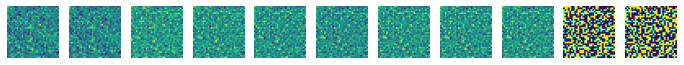

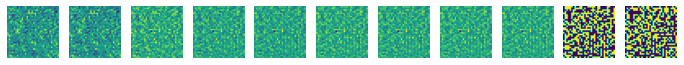

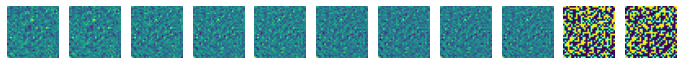

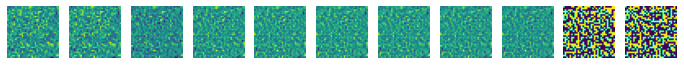

In [18]:
ct = 4
n = 50
rand_noise = torch.randn((ct, channels, subgraph_size, subgraph_size))

generated_samples = unet.sample_from(
    model, 
    image_size=subgraph_size, 
    initial_images=rand_noise.to(device), 
    channels=channels, 
    scheduler=scheduler, 
    timesteps=timesteps,
    num_steps=timesteps
)

print(f"Generating from noise with timesteps={timesteps} (showing n={n})")
for k in range(ct):
    pics = [rand_noise[k].squeeze()]
    for i in range(int(len(generated_samples) / n)):
        cur = generated_samples[i * n][k].squeeze()
        pics.append(cur)
    pics.append(generated_samples[-1][k].squeeze() > 0)
    pics.append(mirror(pics[-1]))
    showAll(pics, size=12)

# Show a sample generated from a sample

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F

for x in dataloader:
    print(x['pixel_values'].shape)
    break

def addNoise(x_start, device, steps, timesteps, scheduler):
    def q_sample(x_start, t, betas, noise=None):
        def extract(a, t, x_shape):
            batch_size = t.shape[0]
            out = a.gather(-1, t.cpu())
            return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
            
        if noise is None:
            noise = torch.randn_like(x_start)

        # define alphas 
        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
        sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

        sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(
            sqrt_one_minus_alphas_cumprod, t, x_start.shape
        )

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    
    t = torch.full((x_start.shape[0],), steps).cpu()
    x_noisy = q_sample(x_start=x_start, t=t, betas=scheduler(timesteps=timesteps), noise=None)

    return x_noisy

torch.Size([128, 1, 16, 16])


In [ ]:
sample_graphs = []

def get_sample():
    return method(subgraph_size, g)

def to_img(graph):
    return (graph.adj().to_dense().unsqueeze(0) * 2) - 1

ct = 512
target = 300
n = 50
clean_samples = torch.zeros(ct, channels, subgraph_size, subgraph_size)
for i in range(ct):
    graph = get_sample()
    sample_graphs.append(graph)
    clean_samples[i] = to_img(graph)

noisy_samples = addNoise(
    x_start=clean_samples,
    device=device,
    steps=target,
    timesteps=timesteps,
    scheduler=scheduler
)

pure_samples = unet.sample_from(
    model, 
    image_size=subgraph_size, 
    initial_images=noisy_samples.to(device), 
    channels=channels, 
    scheduler=scheduler, 
    timesteps=timesteps,
    num_steps=target
)

sampling loop time step: 100%|██████████| 300/300 [00:08<00:00, 34.97it/s]


Adding timesteps=300 of noise to sample, then purifying with timesteps=300 (showing n=50)


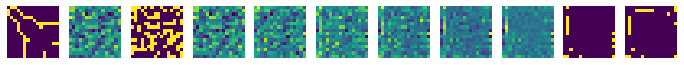

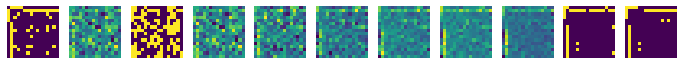

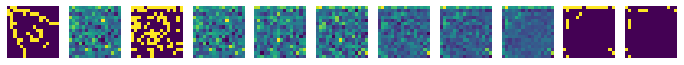

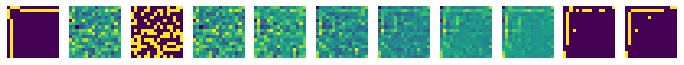

In [ ]:
print(f"Adding timesteps={target} of noise to sample, then purifying with timesteps={target} (showing n={n})")
for k in range(4):
    pics = [clean_samples[k].squeeze()]
    pics.append(noisy_samples[k].squeeze())
    pics.append(noisy_samples[k].squeeze() > 0)
    # pics.append(torch.ones_like(clean_samples[k].squeeze()))
    for i in range(int(len(pure_samples) / n)):
        cur = pure_samples[i * n][k].squeeze()
        pics.append(cur)
    pics.append(pure_samples[-1][k].squeeze() > 0)
    pics.append(mirror(pics[-1]))
    showAll(pics, size=12)

In [ ]:
def test_acc_gcn(model, graph):
    pred = model(graph.ndata['feat'], graph.adj().to_dense()).argmax(dim=1)
    correct = (pred==graph.ndata['label'])[graph.ndata['test_mask']].sum().item()
    return (correct / (graph.ndata['test_mask'].sum())).item()

In [ ]:
from lib.model import DenseGCN
from lib.model import SimpleMLP
from tqdm import tqdm

in_loops = 1

def train_model(model, adj_list, graph_list, epochs):
    t = tqdm(range(epochs), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    t.set_description("GCN Sample Training")
    optimizer = torch.optim.Adam(model.parameters(), lr=model.lr, weight_decay=model.weight_decay)
    
    for i in t:
        loss = 0
        for (i, adj) in enumerate(adj_list):
            clean_graph = graph_list[i]
            pred = model(clean_graph.ndata['feat'], adj)
            loss += F.cross_entropy(pred, clean_graph.ndata['label'])

        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            t.set_postfix({
                "loss": loss.item(), 
                "acc": f"{test_acc_gcn(model, g):.2%}"
            })

In [ ]:
def trial(adj_list, prefix, epochs):
    gcn = DenseGCN.DenseGCN(
        in_size=g.ndata['feat'].shape[1],
        hid_size=32,
        out_size=int(g.ndata['label'].max() + 1),
        lr=1e-2
    )

    train_model(gcn, adj_list, sample_graphs, epochs)
    print(f"{prefix} accuracy: {test_acc_gcn(gcn, g):.2%}")
    return gcn

In [ ]:
def torch_mirror(A: torch.Tensor):
    triu = A.triu()
    triu = triu + triu.rot90(1).flip([0])
    triu.fill_diagonal_(0)
    return triu

clean_adjs = [x.adj().to_dense().int() for x in sample_graphs]
noisy_adjs = [torch_mirror((x > 0).squeeze().int()) for x in noisy_samples]
purified_adjs = [torch_mirror(torch.tensor(x[-1] > 0).squeeze().int()) for x in pure_samples]

In [ ]:
clean_gcn = trial(clean_adjs, "clean adj", 100)
noise_gcn = trial(noisy_adjs, "noisy adj", 100)
purified_gcn = trial(purified_adjs, "purified adj", 100)

GCN Sample Training: 100%|██████████| 100/100 [00:42<00:00,  2.33it/s, loss=518, acc=69.30%]


clean adj accuracy: 69.60%


GCN Sample Training: 100%|██████████| 100/100 [00:42<00:00,  2.38it/s, loss=862, acc=47.10%]


noisy adj accuracy: 44.50%


GCN Sample Training: 100%|██████████| 100/100 [00:25<00:00,  3.91it/s, loss=357, acc=63.00%]

purified adj accuracy: 65.80%


# Misc

In [ ]:
train_data = [x["pixel_values"].squeeze() for x in dataset]

In [ ]:
start = torch.zeros((batch_size,channels,subgraph_size,subgraph_size))
for i in range(8):
    for j in range(8):
        start[0][0][i][j] = 1

out = addNoise(
    x_start=start,
    device=device,
    steps=0,
    timesteps=timesteps,
    scheduler=scheduler
)

print(start[0].mean(), start[0].var())
print(out[0].mean(), out[0].var())

showPic(start[0].squeeze())
showPic(out[0].squeeze())

tensor(0.2500) tensor(0.1882)
tensor(0.2497) tensor(0.1877)


NameError: name 'showPic' is not defined

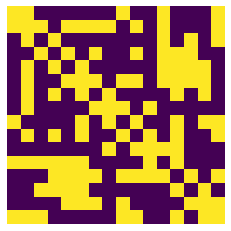

In [ ]:
import matplotlib.pyplot as plt

def showPics(num, imgs):
    plt.figure()
    f, axarr = plt.subplots(1, num, figsize=(15,15))
    rand = random.sample(range(len(imgs)), num)
    for i, imgIdx in enumerate(rand):
        # print(i['pixel_values'][0].squeeze().shape)
        axarr[i].imshow(imgs[imgIdx])
        axarr[i].axis('off')
        if i == num - 1: break


def showPic(img):
    plt.figure()
    # f, axarr = plt.subplots(1, 1, figsize=(15,15))
    # rand = random.sample(range(len(imgs)), num)
    plt.imshow(img)
    plt.axis('off')

def mirror(A: np.ndarray):
    return np.tril(A) + np.triu(A.T, 1)

train_data = [x["pixel_values"].squeeze() for x in dataset]
pred_data = [mirror(x.squeeze()) for x in (samples[-1].squeeze() > 0)]

# comparisons = 5
# showPics(comparisons, train_data)
# showPics(comparisons, pred_data)
showPic(pred_data[-1])